# Shallow Embedding Methods

Shallow embedding methods refer to a category of algorithms that generate fixed, static vector representations for the input data, typically without involving deep learning architectures or dynamic updates during downstream tasks.

## Matrix Factorization

Matrix factorization is a broadly applicable decomposition technique used across various fields. In the context of graph embedding, it serves as a foundational method for deriving low-dimensional node representations from a graph’s structure.

Several graph embedding techniques leverage matrix factorization to capture structural properties. In this section, we introduce two prominent algorithms:

- **Graph Factorization (GF)**
- **Higher-Order Proximity preserved Embedding (HOPE)**

Both approaches use matrix factorization to compute node embeddings that preserve different aspects of the graph’s topology.


Let $W \in \mathbb{R}^{m \times n}$ represent the input data matrix. Matrix factorization aims to approximate this matrix as the product of two lower-dimensional matrices:  
$W \approx V \times H$  
where $V \in \mathbb{R}^{m \times d}$ and $H \in \mathbb{R}^{d \times n}$ are referred to as the **source** and **abundance** matrices, respectively. The parameter $d$ indicates the dimensionality of the embedding space.  

The matrix factorization process involves learning $V$ and $H$ by minimizing a loss function, typically defined as the reconstruction error. A commonly used form is the Frobenius norm:  
$\left\| W - V \times H \right\|_F^2$  

This fundamental approach underlies many unsupervised graph embedding methods. These techniques represent the input graph as a matrix (such as an adjacency or proximity matrix) and decompose it to capture structural relationships. While the core principle is consistent across different models, they differ in how the loss function is defined. Different loss formulations allow the learned embedding space to highlight specific properties of the graph structure.


In [1]:
import matplotlib.pyplot as plt

def draw_graph(G, node_names={}, node_size=500):
    pos_nodes = nx.spring_layout(G)
    nx.draw(G, pos_nodes, with_labels=True, node_size=node_size, edge_color='gray', arrowsize=30)
    
    pos_attrs = {}
    for node, coords in pos_nodes.items():
        pos_attrs[node] = (coords[0], coords[1] + 0.08)
        
    #nx.draw_networkx_labels(G, pos_attrs, font_family='serif', font_size=20)
    
    plt.axis('off')
    axis = plt.gca()
    axis.set_xlim([1.2*x for x in axis.get_xlim()])
    axis.set_ylim([1.2*y for y in axis.get_ylim()])
    plt.show()

## Graph Factorization

Graph Factorization (GF) was among the earliest models designed to efficiently compute node embeddings for a given graph. It follows the general matrix factorization principle described earlier, and specifically factorizes the adjacency matrix of the graph.

Formally, let $G = (V, E)$ be the input graph, and let $A \in \mathbb{R}^{|V| \times |V|}$ denote its adjacency matrix. The GF algorithm aims to learn a low-dimensional embedding matrix $Y \in \mathbb{R}^{|V| \times d}$, where each row $Y_{i,:}$ corresponds to the $d$-dimensional embedding of node $i$.

The loss function used in GF is defined as:

$$
L = \frac{1}{2} \sum_{(i,j)\in E} \left(A_{i,j} - Y_{i,:} Y_{j,:}^\top \right)^2 
+ \frac{\lambda}{2} \sum_i \left\| Y_{i,:} \right\|^2
$$

Here, $(i, j) \in E$ indicates an edge in the graph, and $\lambda$ is a regularization coefficient that helps prevent overfitting and ensures the stability of the optimization, especially in sparse graphs.

The first term in the loss measures the reconstruction error between the actual adjacency values and the inner product of the corresponding node embeddings. The second term penalizes large embedding values to control model complexity.


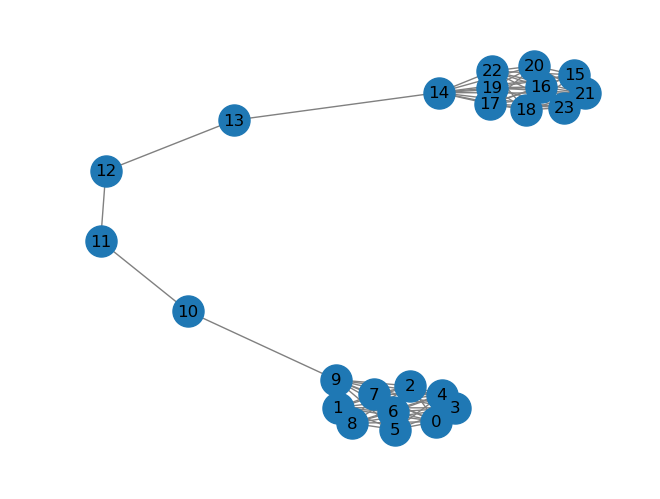

In [6]:
import networkx as nx

G = nx.barbell_graph(m1=10, m2=4)
draw_graph(G)


In [7]:
#!pip install git+https://github.com/palash1992/GEM.git

In [8]:
from pathlib import Path
Path("gem/intermediate").mkdir(parents=True, exist_ok=True)

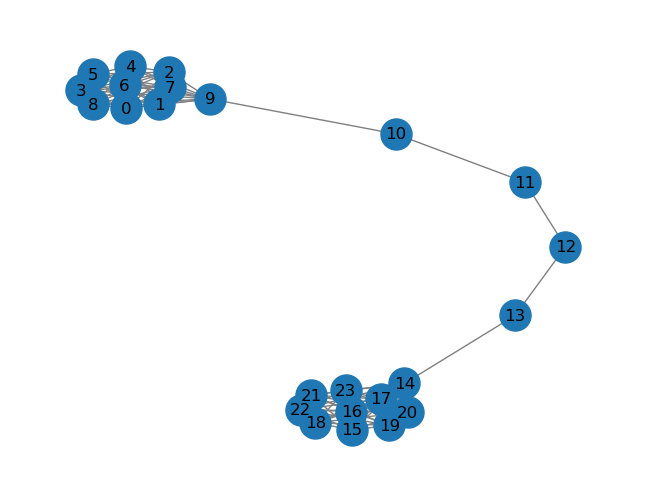

./gf not found. Reverting to Python implementation. Please compile gf, place node2vec in the path and grant executable permission


array([[ 4.38580934e-03,  1.58506207e-03],
       [ 4.38239105e-03,  1.58344919e-03],
       [ 4.38325950e-03,  1.58785960e-03],
       [ 4.38034995e-03,  1.58864119e-03],
       [ 4.41685773e-03,  1.59596599e-03],
       [ 4.34496019e-03,  1.55269236e-03],
       [ 4.45948770e-03,  1.45096428e-03],
       [ 3.49231867e-03,  2.65110933e-03],
       [ 6.93625611e-03,  8.20729084e-04],
       [ 5.18859490e-03,  2.37763712e-05],
       [ 3.35791120e-03,  5.30764399e-03],
       [-8.45192171e-05,  3.41953591e-03],
       [ 2.39650027e-03, -5.34674641e-04],
       [ 3.64820288e-03, -1.88159879e-03],
       [-4.78666189e-04, -1.65773850e-03],
       [-4.76093231e-04, -1.65904057e-03],
       [-4.75475457e-04, -1.65724795e-03],
       [-5.06885058e-04, -1.65756350e-03],
       [-4.60605862e-04, -1.65039562e-03],
       [-4.87607607e-04, -1.69533603e-03],
       [-5.00055667e-04, -1.95723814e-03],
       [ 7.59754411e-05, -8.71532714e-04],
       [-2.76706351e-04, -4.39008834e-03],
       [-2.

In [9]:
#Instead of this old library, we use newer one
from gem.embedding.gf import GraphFactorization

G = nx.barbell_graph(m1=10, m2=4)
draw_graph(G)

gf = GraphFactorization(d=2,  data_set=None,max_iter=10000, eta=1*10**-4, regu=1.0)
gf.learn_embedding(G)

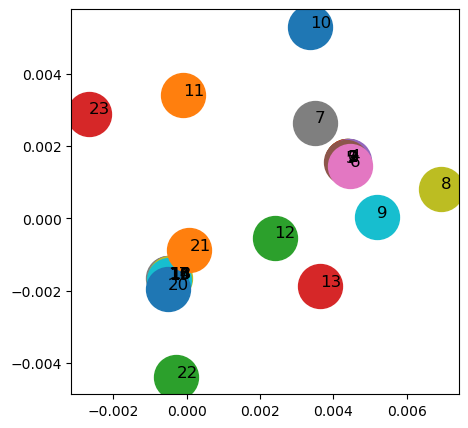

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5,5))

for x in G.nodes():
    
    v = gf.get_embedding()[x]
    ax.scatter(v[0],v[1], s=1000)
    ax.annotate(str(x), (v[0],v[1]), fontsize=12)

# Graph Representation with Global Structure Information (GraphRep)

GraphRep is a family of graph embedding methods that preserve **global structural information**. A well-known example is **HOPE (High-Order Proximity preserved Embedding)**, which captures **higher-order node proximity** without requiring embeddings to be symmetric.

## Motivation

Most basic embedding methods capture only first-order (direct links) or second-order (shared neighbors) proximities. However, **global proximity** (longer-range relationships between nodes) often reveals richer structure. GraphRep methods address this by considering multiple steps (orders) of proximity in the graph.

---

## Notation and Setup

Let:

- $ G = (V, E) $: input graph with $ |V| $ nodes  
- $ A \in \mathbb{R}^{|V| \times |V|} $: adjacency matrix  
- $ D $: diagonal **degree matrix**, defined as:

  $$
  D_{ij} =
  \begin{cases}
  \sum_p A_{ip}, & \text{if } i = j \\
  0, & \text{otherwise}
  \end{cases}
  $$

- $ X^k \in \mathbb{R}^{|V| \times |V| }$: the **k-th order proximity matrix**  
- $ Y_s^k, Y_t^k \in \mathbb{R}^{|V| \times d} $: embedding matrices for source and target nodes  
- $ d $: dimension of embeddings per proximity order  
- $ K $: maximum order of proximity  

---

## What is the $ k $th-Order Proximity?

The **$ k $th-order proximity** measures how strongly two nodes are connected by walks of length $ k $. It is calculated using the **transition probability matrix**:

- First-order transition matrix:
  $
  X^1 = D^{-1} A
  $
  where $ X^1_{ij} $ gives the probability of moving from node $ v_i $ to $ v_j $ in one step.

- Higher-order transition matrix:
  $
  X^k = (D^{-1} A)^k
  $
  where $ X^k_{ij} $ is the probability of moving from $ v_i $ to $ v_j $ in exactly $ k $ steps.

---

## Objective Function

For each proximity order $ k $, the loss function is defined as:

$
L_k = \left\| X^k - Y_s^k \cdot \left(Y_t^k\right)^{T} \right\|_F^2 \quad \text{for } 1 \leq k \leq K
$

- $ \|\cdot\|_F $ is the **Frobenius norm**  
- This loss measures how well the embedding matrices approximate the proximity matrix $ X^k $

Each $ L_k $ is minimized **independently** to learn the embedding matrices $ Y_s^k $ and $ Y_t^k $.

---

## Final Embedding Construction

After optimization, the final embedding for each node is constructed by **concatenating** the source embeddings from all orders:

$
Y_s = \left[ Y_s^1 \ \| \ Y_s^2 \ \| \ \cdots \ \| \ Y_s^K \right] \in \mathbb{R}^{|V| \times (d \cdot K)}
$

- **Number of rows**: $ |V| $ (one per node)  
- **Number of columns**: $ d \cdot K$

This way, each node has a composite embedding that captures multi-step structural information.

---

## Parameters

- `dimension`: the embedding dimension per proximity order ($ d $)  
- `order`: the maximum number of proximity steps considered ($K $)  
- Final embedding dimension per node: $ d \times K $  

---

## Summary

GraphRep methods (like HOPE):

- Capture **high-order proximity** and **global graph structure**
- Use **random walk transition matrices** up to $ K $ steps
- Allow for **asymmetric embeddings** in directed graphs
- Construct embeddings via **matrix factorization**
- Combine embeddings from each proximity order to form the final representation



In this implementation,
the dimension parameter represents the dimension of the embedding space, while the
order parameter defines the maximum number of orders of proximity between nodes.
The number of columns of the final embedding matrix (stored, in the example, in the
embeddings variable) is dimension*order, since, as we said, for each proximity
order an embedding is computed and concatenated in the final embedding matrix.

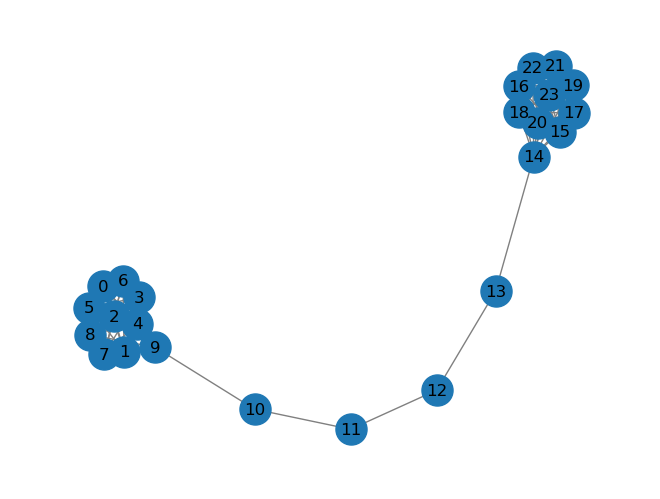

In [14]:
import networkx as nx
from karateclub.node_embedding.neighbourhood.grarep import GraRep

G = nx.barbell_graph(m1=10, m2=4)
draw_graph(G)

gr = GraRep(dimensions=2,order=3)
gr.fit(G)

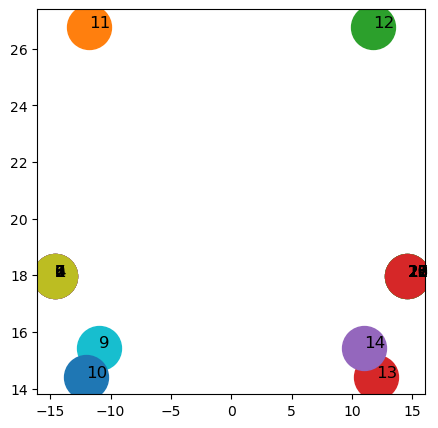

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5,5))
# Since dimensions=2 and order=3, we have 6 dimensions embedded space.
ida = 3
idb = 4
for x in G.nodes():
    
    v = gr.get_embedding()[x]
    ax.scatter(v[ida],v[idb], s=1000)
    ax.annotate(str(x), (v[ida],v[idb]), fontsize=12)

## Higher-order proximity preserved embedding ( HOPE)
HOPE is another graph embedding technique based on the matrix factorization principle.
This method allows preserving higher-order proximity and does not force its embeddings
to have any symmetric properties. 


## HOPE: High-Order Proximity Preserved Embedding

Given the notion of high-order proximity in graphs, the **HOPE** algorithm is designed to generate node embeddings that preserve these structural relationships, particularly in **directed** graphs where proximity is often asymmetric.

Let the input graph be defined as:

- $G = (V, E)$: a graph with node set $V$ and edge set $E$  
- $A \in \mathbb{R}^{|V| \times |V|}$: the adjacency matrix of $G$

The goal is to approximate a **similarity matrix** $S$ using two separate embedding matrices, one for source nodes and another for target nodes. The optimization objective (loss function) is defined as:

$$
L = \left\| S - Y_s \cdot Y_t^{T} \right\|_F^2
$$

Where:

- $S \in \mathbb{R}^{|V| \times |V|}$ is a similarity matrix derived from graph $G$ that encodes high-order proximity between nodes  
- $Y_s \in \mathbb{R}^{|V| \times d}$: source embedding matrix  
- $Y_t \in \mathbb{R}^{|V| \times d}$: target embedding matrix  
- $d$ is the embedding dimensionality  
- $\|\cdot\|_F$ denotes the Frobenius norm

The use of **separate embeddings for source and target nodes** allows HOPE to effectively capture **asymmetric** relationships in the graph—common in many real-world networks such as citation, hyperlink, or follower graphs.

### Final Embedding Construction

The final embedding of each node is obtained by **concatenating** its source and target embeddings:

$$
Y = [Y_s \,|\, Y_t] \in \mathbb{R}^{|V| \times 2d}
$$

This means each node is ultimately represented in a $2d$-dimensional space.

---

### Similarity Matrix Computation

The similarity matrix $S$ is designed to reflect higher-order proximities between nodes and is computed as:

$$
S = M_g \cdot M_l
$$

where both $M_g$ and $M_l$ are matrix polynomials chosen based on the desired similarity measure. For example, when using the **Adamic-Adar (AA)** similarity measure, we have:

- $M_g = I$ (identity matrix)  
- $M_l = A D A$, where:

  - $A$ is the adjacency matrix  
  - $D$ is a diagonal matrix defined as:

    $$
    D_{ii} = \frac{1}{\sum_j (A_{ij} + A_{ji})}
    $$

This formulation highlights the importance of shared neighbors weighted by node degrees, which is characteristic of the Adamic-Adar method.


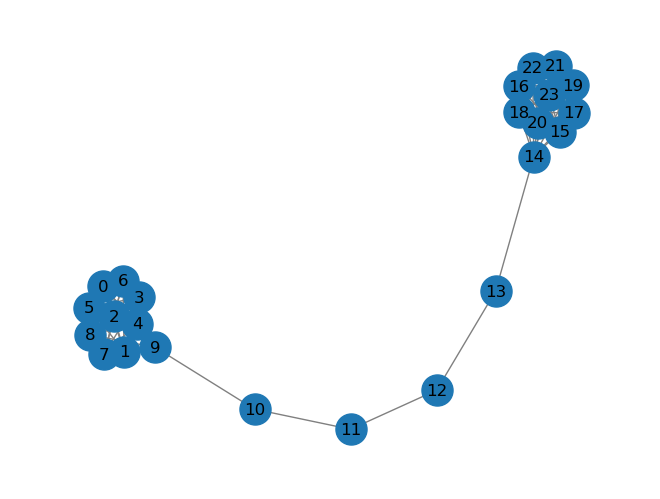

SVD error (low rank): 0.052092


array([[-0.07024409, -0.07024348, -0.07024409, -0.07024348],
       [-0.07024409, -0.07024348, -0.07024409, -0.07024348],
       [-0.07024409, -0.07024348, -0.07024409, -0.07024348],
       [-0.07024409, -0.07024348, -0.07024409, -0.07024348],
       [-0.07024409, -0.07024348, -0.07024409, -0.07024348],
       [-0.07024409, -0.07024348, -0.07024409, -0.07024348],
       [-0.07024409, -0.07024348, -0.07024409, -0.07024348],
       [-0.07024409, -0.07024348, -0.07024409, -0.07024348],
       [-0.07024409, -0.07024348, -0.07024409, -0.07024348],
       [-0.07104037, -0.07104201, -0.07104037, -0.07104201],
       [-0.00797181, -0.00799433, -0.00797181, -0.00799433],
       [-0.00079628, -0.00099787, -0.00079628, -0.00099787],
       [ 0.00079628, -0.00099787,  0.00079628, -0.00099787],
       [ 0.00797181, -0.00799433,  0.00797181, -0.00799433],
       [ 0.07104037, -0.07104201,  0.07104037, -0.07104201],
       [ 0.07024409, -0.07024348,  0.07024409, -0.07024348],
       [ 0.07024409, -0.

In [9]:
import networkx as nx
from gem.embedding.hope import HOPE

G = nx.barbell_graph(m1=10, m2=4)
draw_graph(G)

hp = HOPE(d=4, beta=0.01)
hp.learn_embedding(G)

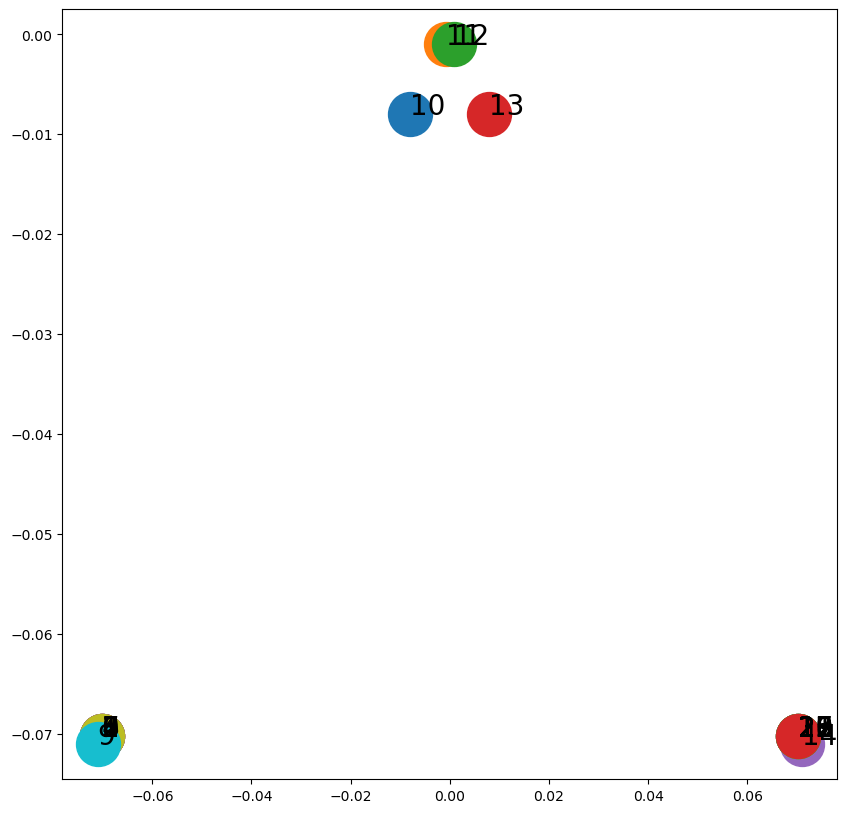

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))

for x in G.nodes():
    
    v = hp.get_embedding()[x,2:]
    ax.scatter(v[0],v[1], s=1000)
    ax.annotate(str(x), (v[0],v[1]), fontsize=20)

In this case, the graph is undirected and thus there is no difference between the source
and target nodes. Figure shows the first two dimensions of the embeddings matrix
representing . It is possible to see how the embedding space generated by HOPE
provides, in this case, a better separation of the different nodes.

## Skip Gram
The skip-gram model is a simple neural network with one hidden layer trained in order to
predict the probability of a given word being present when an input word is present. The
neural network is trained by building the training data using a text corpus as a reference.
This process is described in the following chart:

A target word is selected and a rolling window of fixed size w is built around
that word. The words inside the rolling windows are known as context words. Multiple
pairs of (target word, context word) are then built according to the words inside the rolling
window.

Once the training data is generated from the whole corpus, the skip-gram model is trained
to predict the probability of a word being a context word for the given target. During its
training, the neural network learns a compact representation of the input words. This is
why the skip-gram model is also known as Word to Vector (Word2Vec).

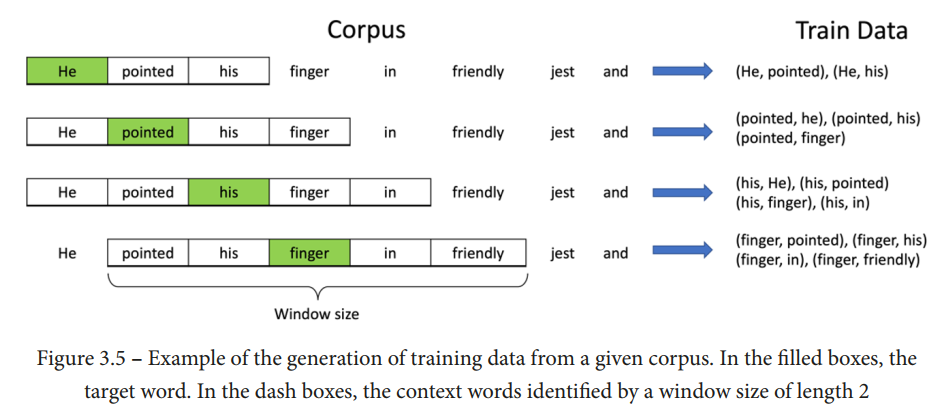

The structure of the neural network representing the skip-gram model is described in the 
following chart:

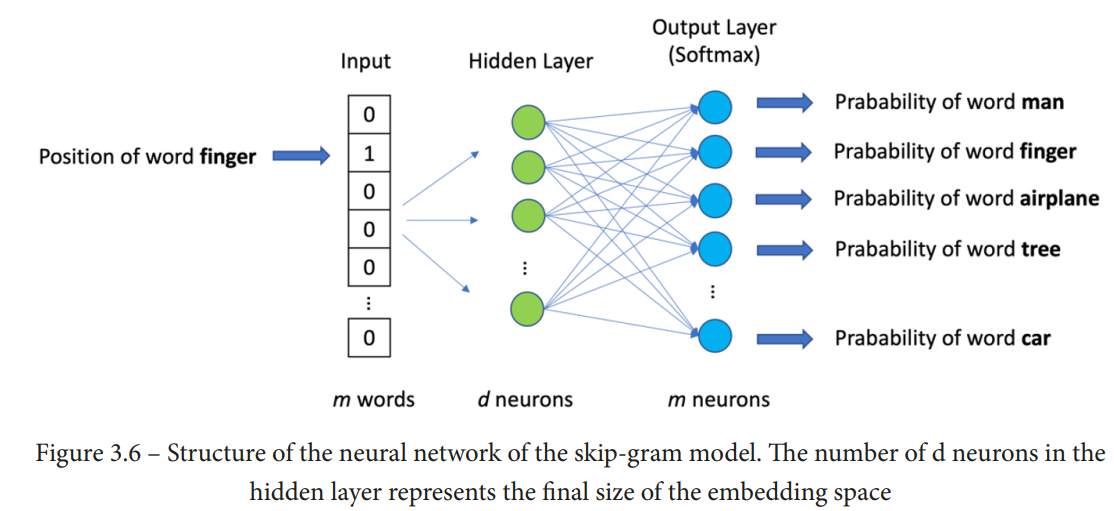

The input of the neural network is a binary vector of size $m$. Each element of the vector represents a word in the dictionary of the language we want to embed the words in. When, during the training process, a (target word, context word) pair is given, the input array will have 0 in all its entries with the exception of the entry representing the "target" word, which will be equal to 1. The hidden layer has d neurons. The hidden layer will learn the embedding representation of each word, creating a d-dimensional embedding space. Finally, the output layer of the neural network is a dense layer of $m$ neurons (the same size as the input vector) with a softmax activation function. Each neuron represents a word of the dictionary. The value assigned by the neuron corresponds to the probability of that word being "related" to the input word. Since softmax can be hard to compute when the 
size of $m$ increases, a hierarchical softmax approach is always used.

The final goal of the skip-gram model is not to actually learn the task we previously described but to build a compact d-dimensional representation of the input words. Thanks to this representation, it is possible to easily extract an embedding space for the words using the weight of the hidden layer. Another common approach to creating a skip-gram model, which will be not described here, is context-based: Continuous Bag-of-Words (CBOW).

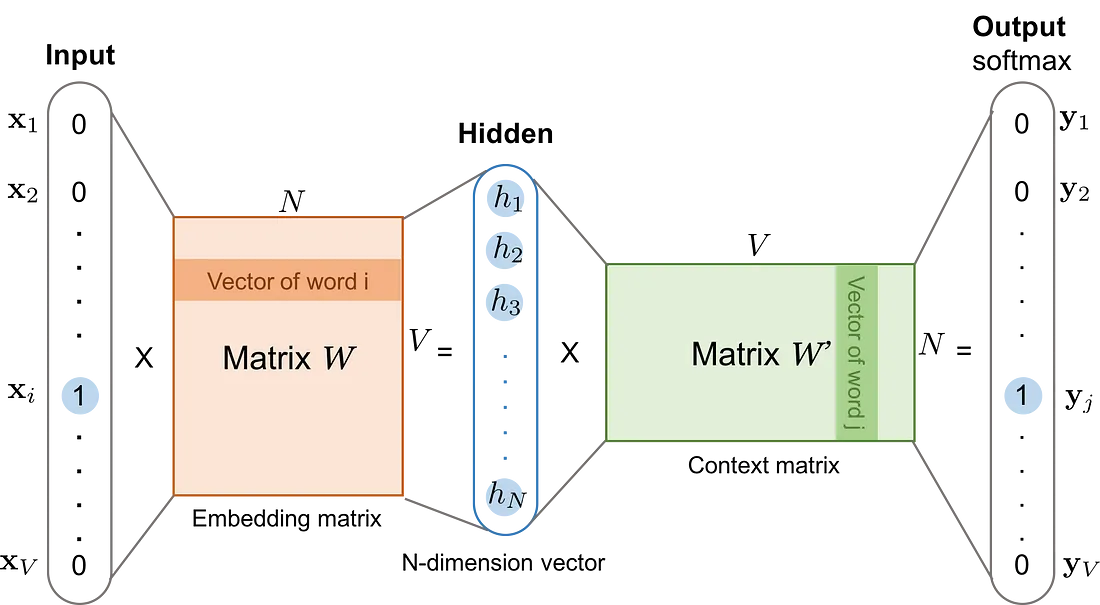
ref:https://medium.com/data-science/complete-guide-to-understanding-node2vec-algorithm-4e9a35e5d147


When training this neural network, the input is a one-hot encoded vector representing the input word, and the output is also a one-hot encoded vector representing the context word. Remember from the previous image how we constructed input and context pairs of words. Word2vec uses a trick where we aren’t interested in the output vector of the neural network, but rather the goal is to learn the weights of the hidden layer. The weights of the hidden layer are actually the word embedding we are trying to learn. The number of neurons in the hidden layer will determine the embedding dimension or the size of the vector representing each word in the vocabulary.

Note that the neural network does not consider the offset of the context word, so it does not differentiate between directly adjacent context words to the input and those more distant in the context window or even if the context word precedes or follows the input term. Consequently, the window size parameter has a significant influence on the results of the word embedding. For example, a study Dependency-Based Word Embeddings by Levy & Goldberg finds that larger context window size tends to capture more topic/domain information. In contrast, smaller windows tend to capture more information about the word itself, e.g., what other words are functionally similar.

## DeepWalk
The DeepWalk algorithm generates the node embedding of a given graph using the skip-gram model. 
In order to provide a better explanation of this model, we need to introduce the concept of **random walks**: 
Formally, let $G$ be a graph and let $v_i$ be a vertex selected as the starting point. We select 
a neighbor of $v_i$ at random and we move toward it. From this point, we randomly select 
another point to move. This process is repeated $t$ times. The random sequence of 
vertices selected in this way is a random walk of length $t$. It is worth mentioning that the 
algorithm used to generate the random walks does not impose any constraint on how they 
are built. As a consequence, there is no guarantee that the local neighborhood of the node 
is well preserved.

Using the notion of random walk, the DeepWalk algorithm generates a random walk of a size of at most $t$ **for each node**. Those random walks will be given as input to the skip-gram model. The embedding generated using skip-gram will be used as the final node embedding. In the following figure (Figure 3.7), we can see a step-by-step graphical representation of the algorithm:
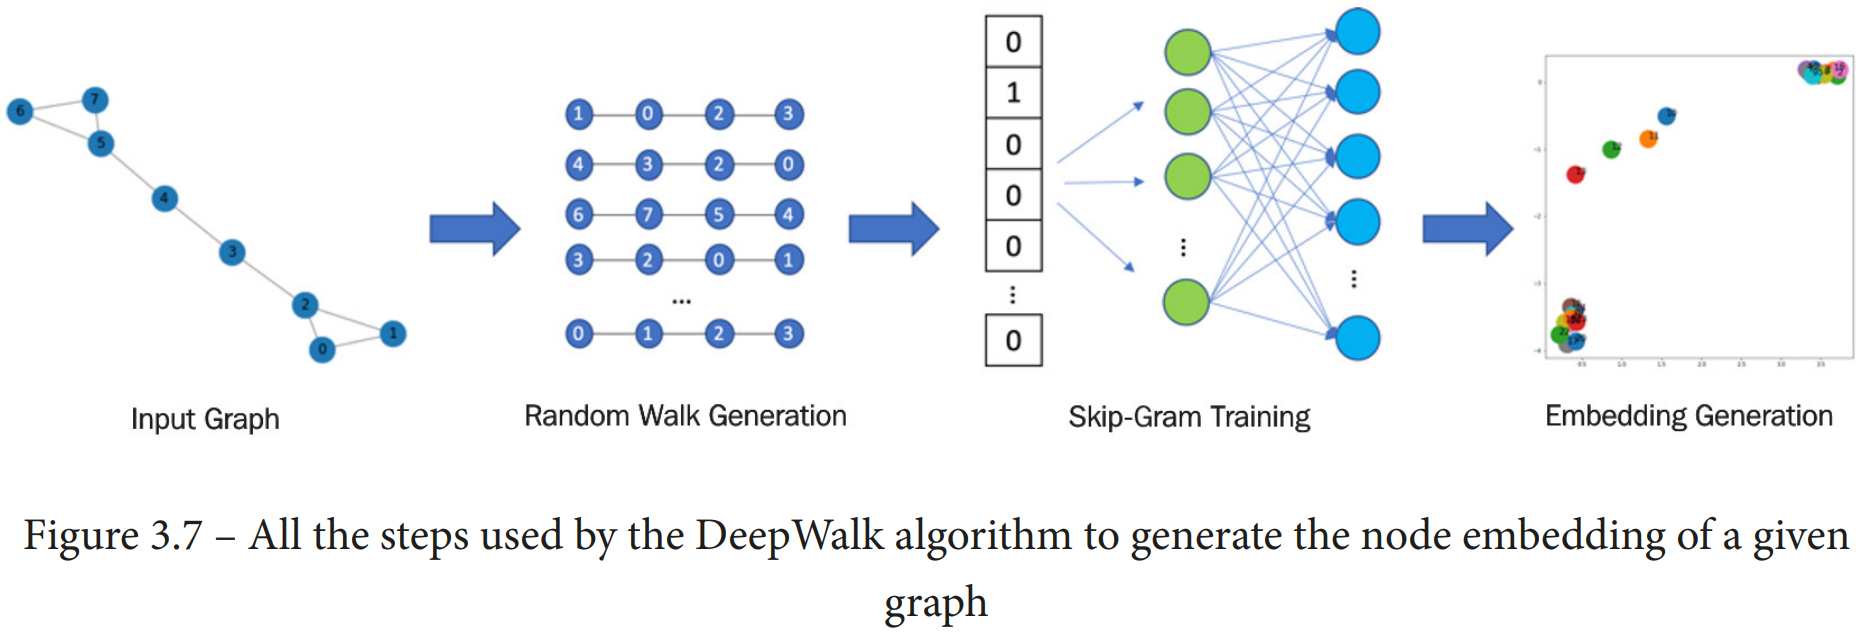
Here is a step-by-step explanation of the algorithm graphically described in the preceding 
chart:

1. **Random Walk Generation**: For each node of input graph $G$, a set of random walks with a fixed maximum length $(t)$ is computed. It should be noted that the length $t$ is an upper bound. There are no constraints forcing all the paths to have the same length.
   
2. **Skip-Gram Training**: Using all the random walks generated in the previous step, a skip-gram model is trained. As we described earlier, the skip-gram model works on words and sentences. When a graph is given as input to the skip-gram model, as visible in Figure 3.7, a graph can be seen as an input text corpus, while a single node of the graph can be seen as a word of the corpus. 
A random walk can be seen as a sequence of words (a sentence). The skip-gram is then trained using the "fake" sentences generated by the nodes in the random walk. The parameters for the skip-gram model previously described (window size, w, and embed size, d) are used in this step.

3. **Embedding Generation**: The information contained in the hidden layers of the 
trained skip-gram model is used in order to extract the embedding of each node

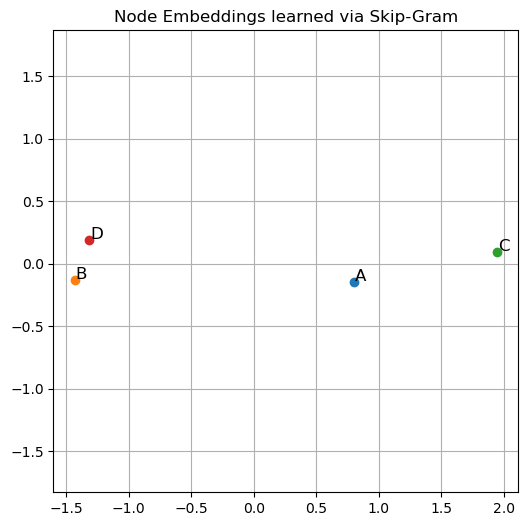

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# فرض کنیم 4 نود داریم: A, B, C, D
nodes = ['A', 'B', 'C', 'D']
node_to_index = {node: i for i, node in enumerate(nodes)}

# وان‌هات ورودی‌ها
def one_hot(index, size=4):
    vec = np.zeros(size)
    vec[index] = 1
    return vec

# داده‌ی آموزش (مرکز → کانتکست)
training_data = [
    ('B', 'C'),
    ('C', 'B'),
    ('C', 'D'),
    ('D', 'C')
]

# پارامترها
vocab_size = 4
embedding_size = 2
np.random.seed(42)

# وزن‌های اولیه
W = np.random.randn(vocab_size, embedding_size)
W_prime = np.random.randn(embedding_size, vocab_size)

# تابع softmax
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

# آموزش خیلی ساده با gradient descent
learning_rate = 0.1
for epoch in range(1000):
    for center, context in training_data:
        center_vec = one_hot(node_to_index[center])
        context_index = node_to_index[context]

        # forward
        h = np.dot(center_vec, W)                  # embedding
        u = np.dot(h, W_prime)                     # نمره برای همه نودها
        y_pred = softmax(u)                        # احتمال‌ها

        # ground truth
        y_true = one_hot(context_index)

        # gradient
        error = y_pred - y_true
        dW_prime = np.outer(h, error)
        dW = np.outer(center_vec, np.dot(W_prime, error))

        # update
        W_prime -= learning_rate * dW_prime
        W -= learning_rate * dW

# نمایش embedding نهایی
embeddings = W
emb_2d = PCA(n_components=2).fit_transform(embeddings)

# رسم
plt.figure(figsize=(6, 6))
for i, label in enumerate(nodes):
    x, y = emb_2d[i]
    plt.scatter(x, y)
    plt.text(x + 0.01, y + 0.01, label, fontsize=12)

plt.title("Node Embeddings learned via Skip-Gram")
plt.grid(True)
plt.axis('equal')
plt.show()


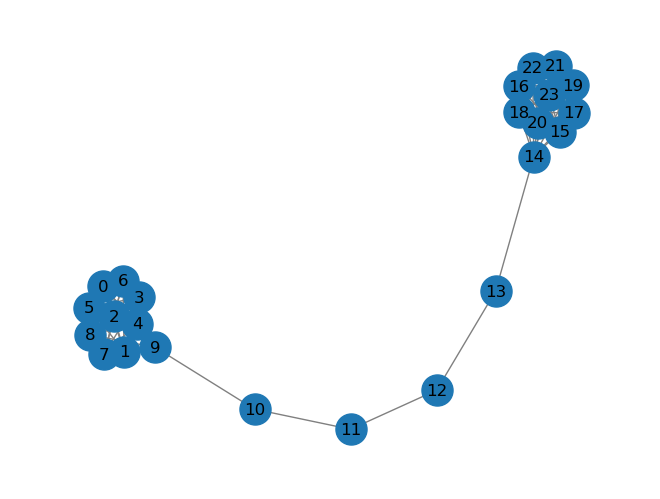

In [20]:
import networkx as nx
from karateclub.node_embedding.neighbourhood.deepwalk import DeepWalk

G = nx.barbell_graph(m1=10, m2=4)
draw_graph(G)

dw = DeepWalk(dimensions=2)
dw.fit(G)

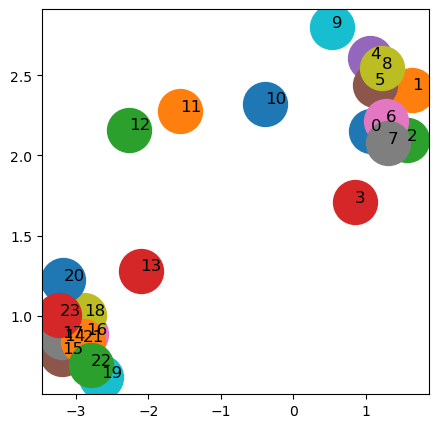

In [22]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5,5))

for x in G.nodes():
    
    v = dw.get_embedding()[x]
    ax.scatter(v[0],v[1], s=1000)
    ax.annotate(str(x), (v[0],v[1]), fontsize=12)

### Negative sampling and subsampling
ref:https://medium.com/data-science/complete-guide-to-understanding-node2vec-algorithm-4e9a35e5d147

The authors of the word2vec skip-gram model have later published a Distributed representations of words and phrases and their compositionality that introduces two optimizations to the original model. The first optimization is the subsampling of frequent words. In any text corpus, the most frequent terms will most likely be the so-called stop words like “the”, “at”, “in”. While the skip-gram model benefits from co-occurrences of words like “Germany” and “Berlin”, the benefit of frequent co-occurrences of “Germany” and “the” is far smaller as nearly every word is accompanied with “the” term. The authors implemented a subsampling technique to address this issue. For each word in the training corpus, there is a chance that we will ignore specific instances of the word in the text. The probability of cutting the word from a sentence is related to the word’s frequency. The research paper shows that subsampling of frequent words during training results in a significant speedup and improves the representations of less frequent words.

The second optimization is the introduction of negative sampling. Training a neural network involves taking a training sample and adjusting all of the neuron weights to predict that training sample more precisely. In layman’s terms, each training sample will tweak all of the weights in the neural network. A Test Your Vocab study shows that most adult native speakers’ vocabulary ranges from 20,000–35,000 words and you can have millions or even billions of input-context training pairs. Updating several thousand weights for every input-context training pair is very expensive. Negative sampling solves this performance issue by having each training sample modify only a small subset of the weights rather than all of them. With negative sampling, a “negative” word is one for which we want the neural network to output a 0, meaning that it is not in the context of our input term. We will still update the weights for our “positive” context word. Experiments indicate that the number of negative samples in the range 5–20 is useful for small training datasets. For larger datasets, the number of negative examples can be as small as 2–5. So, for example, instead of updating all of the neuron weights for each training sample, we only update five negative and one positive weight. This will have a significant impact on the model training time. The paper shows that selecting negative samples using the unigram distribution raised to the 3/4rd power significantly outperformed other options. In a unigram distribution, more frequent words are more probable to be selected as negative samples.

## Node2Vec
The Node2Vec algorithm can be seen as an extension of DeepWalk. This algorithm uses skip-gram with negative sampling (SGNS). Indeed, as with DeepWalk, Node2Vec also generates a set of random walks used as input to a skip-gram model. Once trained, the hidden layers of the skip-gram model are used to generate the embedding of the node in the graph. **The main difference between the two algorithms lies in the way the random walks are generated**. 

Indeed, if DeepWalk generates random walks without using any bias, in Node2Vec a new technique to generate biased random walks on the graph is introduced. The algorithm to generate the random walks combines graph exploration by merging Breadth-First Search (BFS) and Depth-First Search (DFS). The way those two algorithms are combined in the random walk's generation is regularized by two parameters, $p$ and $q$. $p$ defines the probability of a random walk getting back to the previous node, while $q$ defines the probability that a random walk can pass through a previously unseen part of the graph. 
#### Balancing Exploration and Exploitation:

The parameters $p$ and $q$ are crucial in determining the balance between exploration and exploitation during random walks.

A higher value of $p$ encourages revisiting recent nodes, fostering the exploitation of local neighbourhoods.

A lower value of $q$ promotes exploration by allowing the walk to move away from the current node.

Due to this combination, Node2Vec can preserve high-order proximities by preserving local structures in the graph as well as global community structures. This new method of random walk generation allows solving the limitation of DeepWalk preserving the local neighborhood properties of the node.

Node2Vec framework is based on the principle of learning continuous feature representation for nodes in the graph and preserving the knowledge gained from the neighboring 100 nodes.  Lets us understand how the algorithm works.  Say we have a graph having a few interconnected nodes creating a network. So, Node2Vec algorithm learns a dense representation (say 100 dimensions/features) of every node in the network. 

The algorithm suggests that if we plot these 100 dimensions of each node in a 2 dimensional graph by applying PCA, the distance of the two nodes in that low-dimensional graph would be same as their actual distance in the given network. 

In this way, the framework maximizes the likelihood of preserving neighboring nodes even if you represent them in a low-dimensional space.

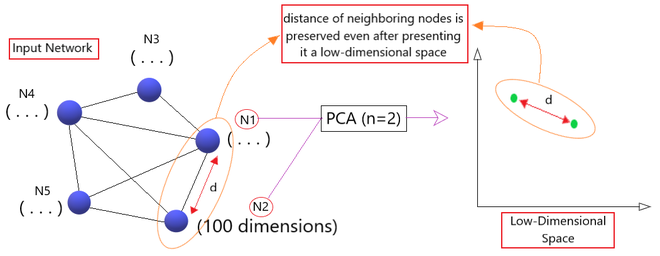


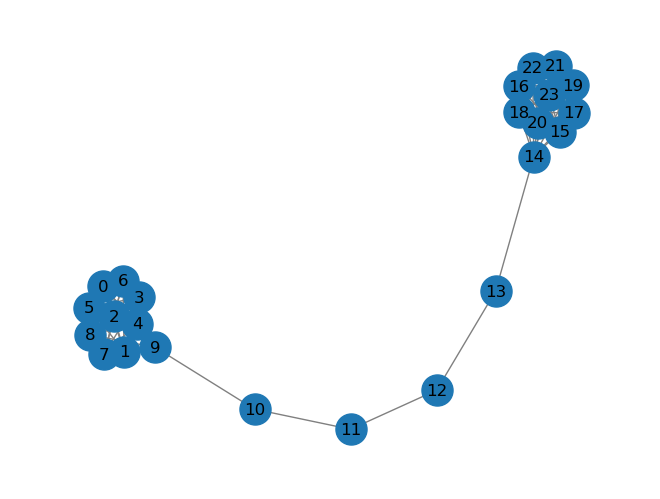

Generating walks (CPU: 1): 100%|███████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.88it/s]


In [24]:
import networkx as nx
from node2vec import Node2Vec

G = nx.barbell_graph(m1=10, m2=4)
draw_graph(G)

node2vec = Node2Vec(G, dimensions=2)
model = node2vec.fit(window=10)
embeddings = model.wv

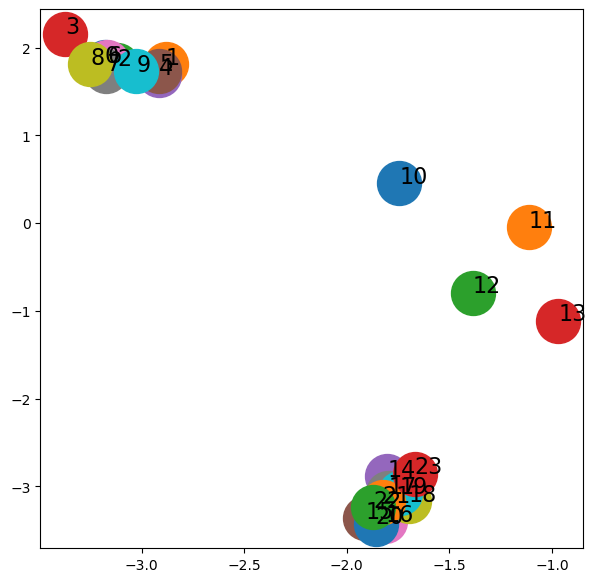

In [26]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7,7))

for x in G.nodes():
    
    v = model.wv[str(x)]
    ax.scatter(v[0],v[1], s=1000)
    ax.annotate(str(x), (v[0],v[1]), fontsize=16)

plt.show()

In [33]:
print(model.wv["1"])

[-2.8825765  1.814908 ]


## Edge2Vec
Contrary to the other embedding function, the Edge to Vector (Edge2Vec) algorithm 
generates the embedding space on edges, instead of nodes. This algorithm is a simple side 
effect of the embedding generated by using Node2Vec. The main idea is to use the node 
embedding of two adjacent nodes to perform some basic mathematical operations in 
order to extract the embedding of the edge connecting them
Formally, let and be two adjacent nodes and let $f(v_i)$ and $f(v_j)$ be their 
embeddings computed with Node2Vec. The operators described in Table 3.1 can be used in order to compute the embedding of their edge:

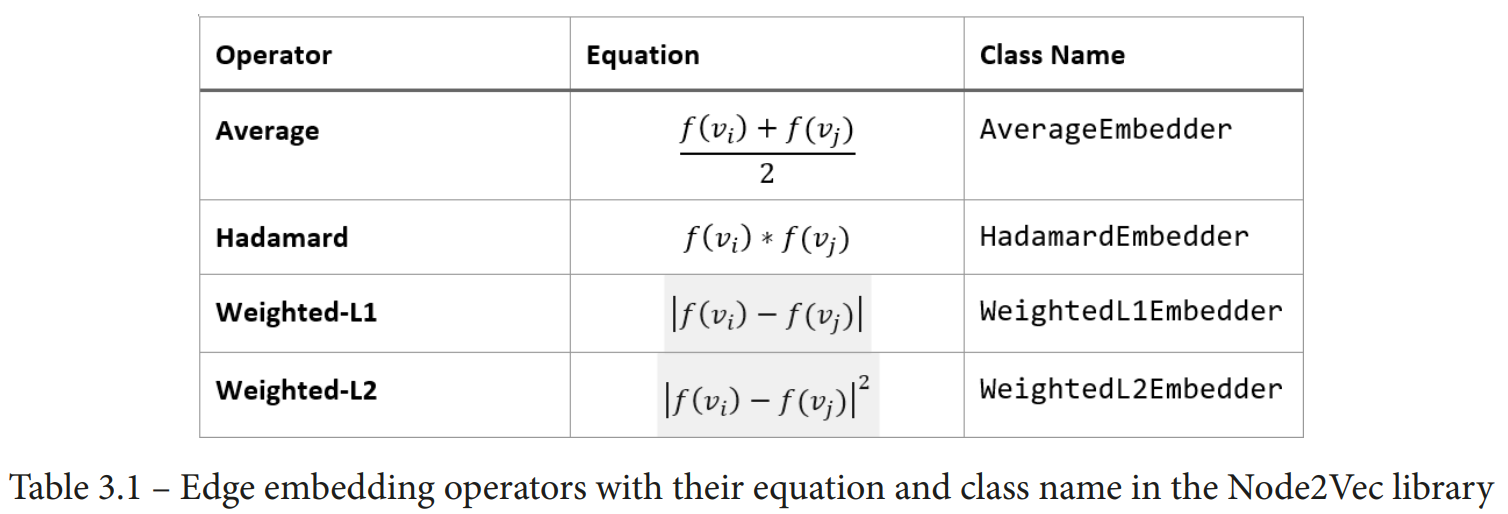

In [15]:
from node2vec.edges import HadamardEmbedder
edges_embs = HadamardEmbedder(keyed_vectors=model.wv)

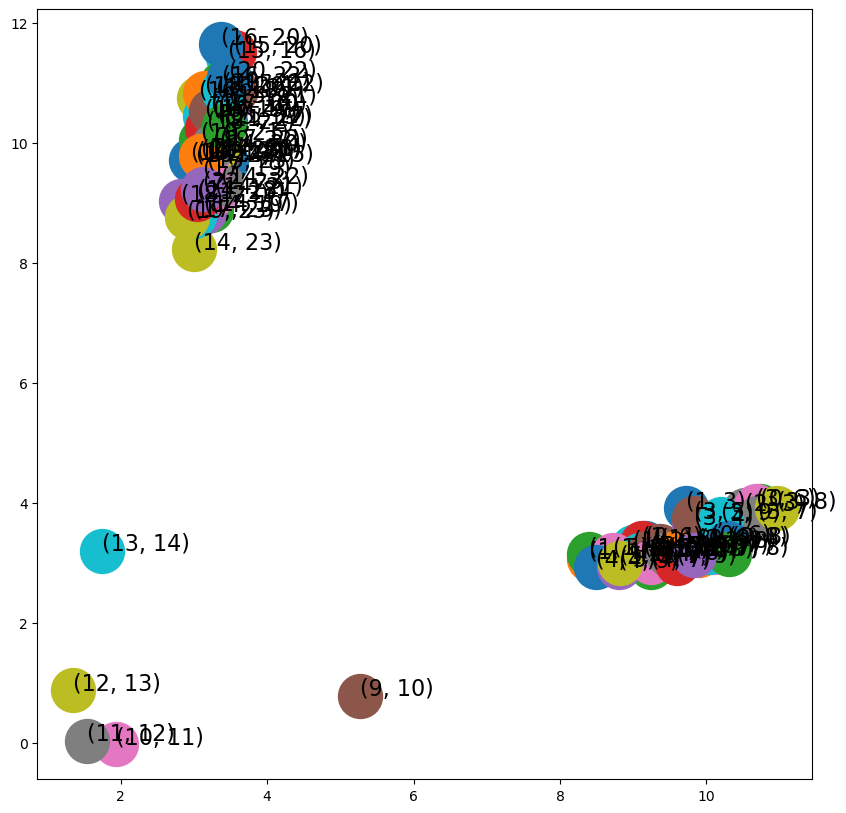

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))

for x in G.edges():
    
    v = edges_embs[(str(x[0]), str(x[1]))]
    ax.scatter(v[0],v[1], s=1000)
    ax.annotate(str(x), (v[0],v[1]), fontsize=16)

plt.show()

## Graph2Vec
The methods we previously described generated the embedding space for each node or edge on a given graph. Graph to Vector (Graph2Vec) generalizes this concept and generates embeddings for the whole graph. 

To specify, given a set of graphs, the Graph2Vec algorithms generate an embedding space where each point represents a graph. This algorithm generates its embedding using an evolution of the Word2Vec skip-gram model known as Document to Vector (Doc2Vec). 

The main idea behind this method is to view an entire graph as a document and each of its subgraphs, generated as an ego graph (see Chapter 1, Getting Started with Graphs) of each node, as words that comprise the document. 

In other words, a graph is composed of subgraphs as a document is composed of sentences. According to this description, the algorithm can be summarized into the 
following steps:
1. Subgraph generation: A set of rooted subgraphs is generated around every node.
2. Doc2Vec training: The Doc2Vec skip-gram is trained using the subgraphs 
generated by the previous step. 
3. Embedding generation: The information contained in the hidden layers of the 
trained Doc2Vec model is used in order to extract the embedding of each node.

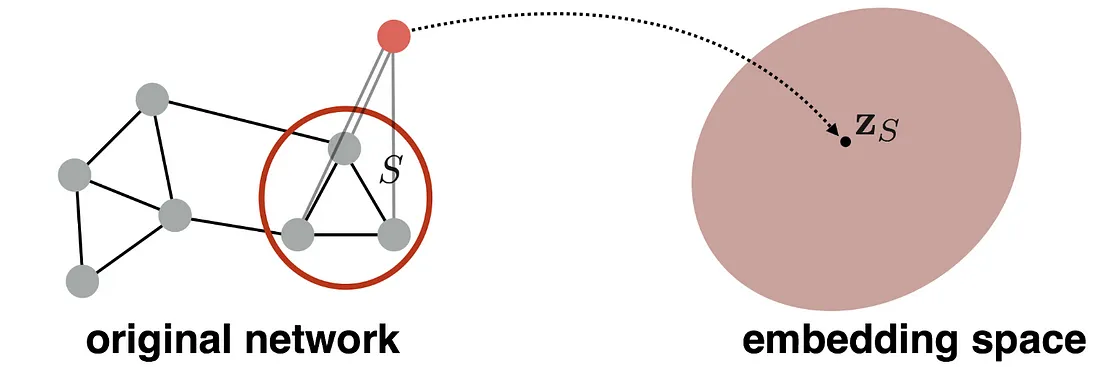


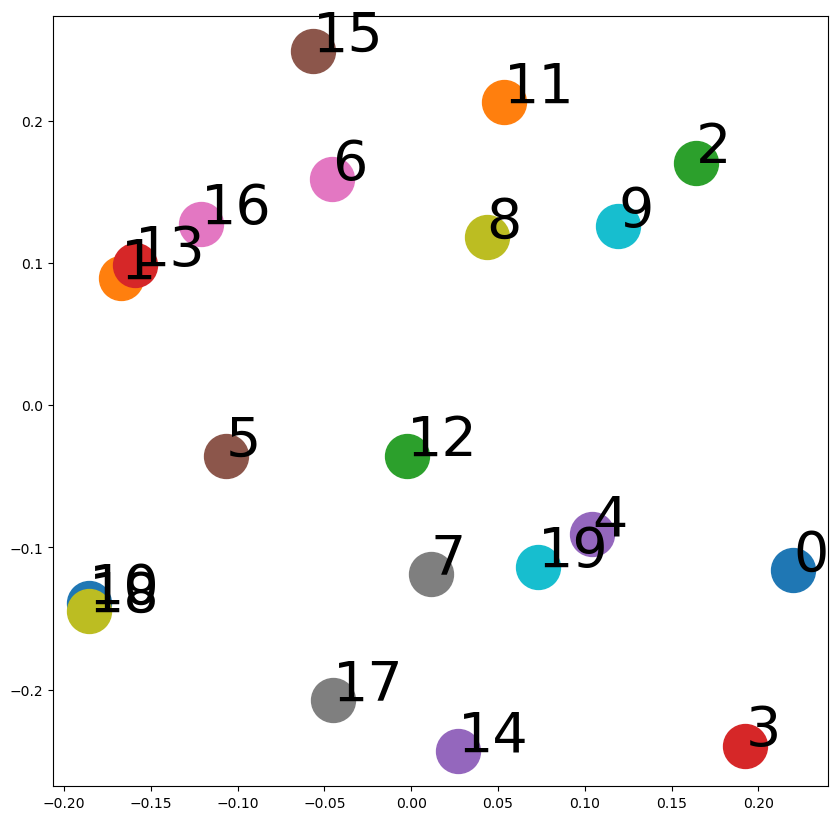

In [17]:
import random
import matplotlib.pyplot as plt
from karateclub import Graph2Vec

n_graphs = 20

def generate_radom():
    n = random.randint(6, 20)
    k = random.randint(5, n)
    p = random.uniform(0, 1)
    return nx.watts_strogatz_graph(n,k,p), [n,k,p]

Gs = [generate_radom() for x in range(n_graphs)]

model = Graph2Vec(dimensions=2, wl_iterations=10)
model.fit([x[0] for x in Gs])
embeddings = model.get_embedding()

fig, ax = plt.subplots(figsize=(10,10))

for i,vec in enumerate(embeddings):
    
    ax.scatter(vec[0],vec[1], s=1000)
    ax.annotate(str(i), (vec[0],vec[1]), fontsize=40)